# Project 4. Wrangle and Analyze Data 

## Data wrangling
### - Gathering data

* 1 I have downloaded the file **twitter_archive_enhanced.csv** manually in workspaces.

* 2 Programmatic download using the library **Request**

In [177]:
import requests
import os

In [178]:
folder_name = 'predictions_dogs'

In [179]:
# Make directory if it doesn't already exist
folder_name = 'predictions_dogs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name,mode=511)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [180]:
with open (os.path.join(folder_name,url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

**TESTING:**

In [181]:
print (os.listdir(folder_name))

['image-predictions.tsv']


* 3 Each tweet's **retweet count and favorite ("like")** count at minimum, and any additional data you find interesting

In [182]:
import tweepy
import numpy as np
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
import time
import regex as re

In [183]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'dM5q4kIqwTEoQzOsXpNS4DceY'
consumer_secret = 'vv8pTvVcxJmFvPqDMdAr4za5HXZKUx6X7yDawArkUpNN1lCQs8'
access_token = '1108105912508657664-bVjVh0DrVy2kzKFX2rHcwSabVFzCaz'
access_secret = '0eE6XN86dRE2Fii7mNZoPYPO2RjQKQFJOXPURHVaVRZbZ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [184]:
# Get the User object for @dog_rates...
user = api.get_user('@dog_rates')

print (user.followers_count)
for friend in user.friends():
   print (friend.screen_name)

7994681
ChronicleBooks
IvePetThatDog
TheVFoundation
FixYourBiz
hess_clint
Summersdale
AndrewsMcMeel
skyhorsepub
dog_feelings
unwise
mackemode
dogfather


In [185]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv')
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

**NOTE:** I charge 'tweet-json.txt' for the Fails and the little time I have

**DataFrame with (at minimum) tweet ID, retweet count, and favorite count**

In [186]:
df = pd.read_json('tweet_json.txt', lines=True)

In [187]:
#read photos dogs
photo_dogs = pd.read_table('predictions_dogs/image-predictions.tsv', sep='\t')

In [188]:
print ('Tweets:',df['id'].count())
print ('Retweets:',df['retweet_count'].sum())
print ('Favorites:', df['favorited'].value_counts())
print ('Sum favorite_count:', df['favorite_count'].sum())

Tweets: 2354
Retweets: 7449933
Favorites: False    2346
True        8
Name: favorited, dtype: int64
Sum favorite_count: 19022600


### - Assessing data
#### **Evaluating data for this project**
After collecting each of the above data, evaluate them visually and programmatically to detect problems of quality and order. Detect and document at least eight (8) quality problems and two (2) cleaning problems on your wrangle_act.ipynbupport Jupyter. To meet the specifications, problems that satisfy the motivation of the project must be evaluated (see the heading Key points on the previous page).
#### eight (8) quality issues
- **contributors, coordinates and geo** They have 0 data. Those columns are eliminated as unnecessary.
- **created_at** it does not have to be on datetime64. Create 3 columns with the year, month and day.
- Line breaks in **full_text**. Remove.
- Aislar el nombre del perro de **full_text**. 
- Extract the url from **full_text** in another column.
- Extract the vote **full_text** in another column.
- **place** has only one record. You can ignore and delete column.

In [189]:
print('********')
print('** df **')
print('********')
print(df.info())
df

********
** df **
********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_t

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [190]:
print('**********')
print('** df_1 **')
print('**********')
print(df_1.info())
df_1

**********
** df_1 **
**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [191]:
print('****************')
print('** photo_dogs **')
print('****************')
print(photo_dogs.info())
photo_dogs

****************
** photo_dogs **
****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [192]:
df['text_split'] = df['full_text'].str.split()

In [193]:
names = []

def extract_names(row):
    # name           
    if 'named' in row['full_text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
    # Here we have 
    elif row['full_text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # This is 
    elif row['full_text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    # Say hello to
    elif row['full_text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # Meet 
    elif row['full_text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    else:
        names.append('withoutname')
        
df.apply(extract_names, axis=1)
df['dog_names'] = names

In [194]:
df.drop(['text_split'], axis='columns', inplace = True)
print (df.dog_names.head())
print (df.dog_names.value_counts().head())

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
Name: dog_names, dtype: object
withoutname    943
Charlie         11
Lucy            11
Cooper          10
Oliver          10
Name: dog_names, dtype: int64


#### Cleaning Data and tidiness issues
##### **Quality problems / Order problems**
- Rename 'id' to match it with the other df's and change it to str
- Eliminate retweets
- Delete columns that we do not use
- Create year, month and day
- Eliminate page breaks in 'full_text'
- change '_' for ' '
- change dog name by its correct name or none
- Separate the **'stage'** of each dog in a new column
- Create rating column concating rating_numerator with rating_denominator

In [195]:
# Copy the dataframes 
df_clean = df_1.copy()
photo_dogs_clean = photo_dogs.copy()
df_tweet_clean = df.copy()

In [196]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [197]:
photo_dogs_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [198]:
df_tweet_clean.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user,dog_names
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Phineas
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Tilly
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Archie
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Darla
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Franklin


- Clearing data from **df_tweet_clean**

In [199]:
# I rename 'id' to match it with the other df's and change it to str
df_tweet_clean.rename(columns={'id': 'tweet_id'}, inplace=True)
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

In [200]:
df_tweet_clean.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user,dog_names
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Phineas
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Tilly
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Archie
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Darla
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Franklin


In [201]:
# Eliminate retweets
df_tweet_clean.drop(df_tweet_clean[df_tweet_clean['retweeted_status'].notnull()== True].index,inplace=True)

In [202]:
df_tweet_clean.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user,dog_names
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Phineas
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Tilly
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Archie
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Darla
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",Franklin


In [203]:
# Delete columns that we do not use, I create year, month and day and I eliminate page breaks in 'full_text'
df_tweet_clean['year'] = df_tweet_clean['created_at'].dt.year
df_tweet_clean['month'] = df_tweet_clean['created_at'].dt.month
df_tweet_clean['day'] = df_tweet_clean['created_at'].dt.day
df_tweet_clean.drop(['contributors',
                     'coordinates',
                     'created_at',
                     'entities',
                     'extended_entities',
                     'favorited',
                     'geo',
                     'id_str',
                     'in_reply_to_screen_name',
                     'in_reply_to_status_id',
                     'in_reply_to_status_id_str',
                     'in_reply_to_user_id',
                     'in_reply_to_user_id_str',
                     'is_quote_status',
                     'lang',
                     'place',
                     'possibly_sensitive',
                     'possibly_sensitive_appealable',
                     'quoted_status',
                     'quoted_status_id',
                     'quoted_status_id_str',
                     'retweeted',
                     'retweeted_status',
                     'source',
                     'truncated',
                     'user'], axis=1,inplace=True)
df_tweet_clean.full_text.replace('\n', ' ')
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2353
Data columns (total 9 columns):
display_text_range    2175 non-null object
favorite_count        2175 non-null int64
full_text             2175 non-null object
tweet_id              2175 non-null object
retweet_count         2175 non-null int64
dog_names             2175 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
day                   2175 non-null int64
dtypes: int64(5), object(4)
memory usage: 169.9+ KB


In [204]:
df_tweet_clean.head()

,display_text_range,favorite_count,full_text,tweet_id,retweet_count,dog_names,year,month,day
0,"[0, 85]",39467,This is Phineas. He's a mystical boy. Only eve...,892420643555336193,8853,Phineas,2017,8,1
1,"[0, 138]",33819,This is Tilly. She's just checking pup on you....,892177421306343426,6514,Tilly,2017,8,1
2,"[0, 121]",25461,This is Archie. He is a rare Norwegian Pouncin...,891815181378084864,4328,Archie,2017,7,31
3,"[0, 79]",42908,This is Darla. She commenced a snooze mid meal...,891689557279858688,8964,Darla,2017,7,30
4,"[0, 138]",41048,This is Franklin. He would like you to stop ca...,891327558926688256,9774,Franklin,2017,7,29


- Clearing data from **photo_dogs_clean**

In [205]:
photo_dogs_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
859,696894894812565505,https://pbs.twimg.com/media/CaveNQcVIAECyBr.jpg,1,Appenzeller,0.665628,True,beagle,0.104795,True,Greater_Swiss_Mountain_dog,0.067868,True
534,676936541936185344,https://pbs.twimg.com/media/CWT2MUgWIAECWig.jpg,1,Chesapeake_Bay_retriever,0.545286,True,Norwegian_elkhound,0.081482,True,space_heater,0.047391,False
294,671355857343524864,https://pbs.twimg.com/media/CVEilyCUwAETbJ-.jpg,1,miniature_poodle,0.313811,True,toy_poodle,0.165585,True,Irish_terrier,0.056094,True
1617,802323869084381190,https://pbs.twimg.com/media/CyJtSmDUAAA2F9x.jpg,4,home_theater,0.765069,False,television,0.203578,False,entertainment_center,0.018644,False
1650,809220051211603969,https://pbs.twimg.com/media/CzrtWDbWEAAmIhy.jpg,1,Pomeranian,0.819511,True,Samoyed,0.141241,True,Pembroke,0.013455,True


In [206]:
# change '_' for ' '
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.replace('_', ' ')
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.replace('_', ' ')
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.replace('_', ' ')
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.title()
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.title()
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.title()

In [207]:
# Change tweet_id to object to match it with the other df
photo_dogs_clean.tweet_id = photo_dogs_clean.tweet_id.astype(str)
photo_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [208]:
photo_dogs_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


- Clearing data from **df_clean**

In [209]:
# I delete the records with data in 'retweeted_status id'
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [210]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [211]:
# Missing Data
# change by its correct name or none
df_clean['name'].replace('the', 'None', inplace=True)
df_clean['name'].replace("light",'None', inplace=True)
df_clean['name'].replace("life",'None', inplace=True)
df_clean['name'].replace("an",'None', inplace=True)
df_clean['name'].replace("a",'None', inplace=True)
df_clean['name'].replace("by",'None', inplace=True)
df_clean['name'].replace("actually",'None', inplace=True)
df_clean['name'].replace("just",'None', inplace=True)
df_clean['name'].replace("getting",'None', inplace=True) 
df_clean['name'].replace("infuriating",'None', inplace=True) 
df_clean['name'].replace("old",'None', inplace=True) 
df_clean['name'].replace("all",'None', inplace=True) 
df_clean['name'].replace("this",'None', inplace=True) 
df_clean['name'].replace("very",'None', inplace=True) 
df_clean['name'].replace("mad",'None', inplace=True) 
df_clean['name'].replace("not",'None', inplace=True)
df_clean['name'].replace("one",'None', inplace=True)
df_clean['name'].replace("my",'None', inplace=True)
df_clean['name'].replace("O","O'Malley", inplace=True)
df_clean['name'].replace("quite","None", inplace=True)
df_clean['name'].replace("such","None", inplace=True)

In [212]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [213]:
# remove these values from the dataframe using the drop() function
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [214]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [215]:
df_clean['stage'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo

In [216]:
df_clean['stage'].unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [217]:
# Separate the 'stage' of each dog in a new column
df_clean['stage'] = df_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: ''.join(x), axis=1)

df_clean['stage'].replace("NoneNoneNoneNone","None ", inplace=True)
df_clean['stage'].replace("doggoNoneNoneNone","doggo", inplace=True)
df_clean['stage'].replace("NoneNoneNonepuppo","puppo", inplace=True)
df_clean['stage'].replace("NoneNonepupperNone","pupper", inplace=True)
df_clean['stage'].replace("NoneflooferNoneNone","floofer", inplace=True)
df_clean['stage'].replace("doggoNoneNonepuppo","doggo,puppo", inplace=True)
df_clean['stage'].replace("doggoflooferNoneNone","doggo,floofer", inplace=True)
df_clean['stage'].replace("doggoNonepupperNone","doggo,pupper", inplace=True)


In [218]:
df_clean['stage'].unique()

array(['None ', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

In [219]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None


In [220]:
# create year, month and day
from datetime import datetime,timedelta
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['day'] = df_clean['timestamp'].dt.day

In [221]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,stage,year,month,day
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,None,2017,8,1
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,None,2017,8,1
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,None,None,None,None,2017,7,31
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,None,None,None,None,None,2017,7,30
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,None,None,None,None,None,2017,7,29


In [222]:
# delete columns that are not going to be used
df_clean.drop(['retweeted_status_user_id',
               'retweeted_status_id',
               'retweeted_status_timestamp',
               'in_reply_to_status_id',
               'in_reply_to_user_id',
               'in_reply_to_status_id',
               'expanded_urls',
               'source',
               'doggo',
               'floofer',
               'pupper',
               'puppo',
               'text'], axis=1,inplace=True)

In [223]:
# The data type is changed to object
df_clean.tweet_id = df_clean.tweet_id.astype(str)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
stage                 2175 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
day                   2175 non-null int64
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 169.9+ KB


In [224]:
# Create rating column concating rating_numerator with rating_denominator
df_clean['rating'] = df_clean['rating_numerator'].map(str) + ',' + df_clean['rating_denominator'].map(str)

In [225]:
df_clean.head()

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year,month,day,rating
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,None,2017,8,1,"13,10"
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,2017,8,1,"13,10"
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,None,2017,7,31,"12,10"
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,2017,7,30,"13,10"
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,None,2017,7,29,"12,10"


#### MERGES 

In [226]:
df_merge = pd.merge(df_clean, df_tweet_clean,on='tweet_id', how='inner')

In [227]:
df_merge = pd.merge(df_merge, photo_dogs_clean,on='tweet_id', how='inner')

In [228]:
df_merge

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year_x,month_x,day_x,rating,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,None,2017,8,1,"13,10",...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,2017,8,1,"13,10",...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,None,2017,7,31,"12,10",...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,2017,7,30,"13,10",...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,None,2017,7,29,"12,10",...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True
5,891087950875897856,2017-07-29 00:08:17,13,10,None,None,2017,7,29,"13,10",...,1,Chesapeake Bay Retriever,0.425595,True,Irish Terrier,0.116317,True,Indian Elephant,0.076902,False
6,890971913173991426,2017-07-28 16:27:12,13,10,Jax,None,2017,7,28,"13,10",...,1,Appenzeller,0.341703,True,Border Collie,0.199287,True,Ice Lolly,0.193548,False
7,890729181411237888,2017-07-28 00:22:40,13,10,None,None,2017,7,28,"13,10",...,2,Pomeranian,0.566142,True,Eskimo Dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,2017-07-27 16:25:51,13,10,Zoey,None,2017,7,27,"13,10",...,1,Irish Terrier,0.487574,True,Irish Setter,0.193054,True,Chesapeake Bay Retriever,0.118184,True
9,890240255349198849,2017-07-26 15:59:51,14,10,Cassie,doggo,2017,7,26,"14,10",...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


#### **Storage, visualization and analisys of data for this project**
As requested, I record in the file twitter_archive_master.csv the merged data of the 3 datasets, df_clean, df_tweet_clean and photo_dogs_clean. I also create a csv file for each of the aforementioned datasets.

#### Store the Cleaned dataframes

In [229]:
# Save to a file twitter_archive_master.csv
folder_name = 'definitivo'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
df_clean.to_csv('definitivo/twitter_master.csv')
photo_dogs_clean.to_csv('definitivo/photo_dogs_master.csv')
df_tweet_clean.to_csv('definitivo/tweet_query_master.csv')
df_merge.to_csv('definitivo/twitter_archive_master.csv')

In [230]:
df_merge.head()

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year_x,month_x,day_x,rating,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,None,2017,8,1,"13,10",...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,2017,8,1,"13,10",...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,None,2017,7,31,"12,10",...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,2017,7,30,"13,10",...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,None,2017,7,29,"12,10",...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


#### **Analisys**
Analyze and visualize your unordered data in your wrangle_act.ipynb Jupyter notebook. At least three (3) ideas and one (1) visualization must be produced.

In [231]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
matplotlib.style.use('seaborn-whitegrid')
df = pd.read_csv('definitivo/twitter_archive_master.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

##### Favorites_count and Retweets_count in time.

Text(0,0.5,'Num')

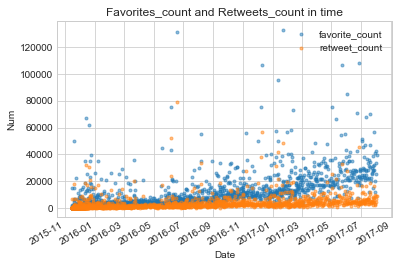

In [232]:
df[['favorite_count', 'retweet_count']].plot(style = '.', alpha = .5)
plt.title('Favorites_count and Retweets_count in time')
plt.xlabel('Date')
plt.ylabel('Num')

The number of tweets and retweets increases as we get closer to today.
It shows that there are more and more users and they are more active.

##### Rating

Text(0,0.5,'Rating')

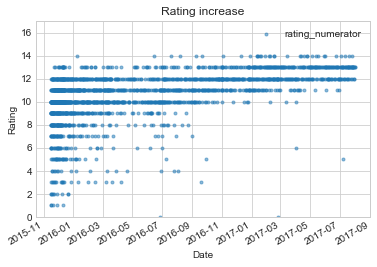

In [233]:
df.plot(y ='rating_numerator', ylim=[0,17], style = '.', alpha = .5)
plt.title('Rating increase')
plt.xlabel('Date')
plt.ylabel('Rating')

We also verify that the qualifications are increasing.

##### Top 20 dog names

In [234]:
# Top 20 dog names
top20_names = df.where(df.name != 'None')
top20_names = top20_names['name'].value_counts().head(20)
top20_names

Charlie    11
Lucy       10
Oliver     10
Cooper     10
Penny       9
Tucker      9
Sadie       8
Winston     8
Daisy       7
Lola        7
Toby        7
Stanley     6
Koda        6
Bo          6
Bella       6
Jax         6
Chester     5
Oscar       5
Rusty       5
Scout       5
Name: name, dtype: int64

Text(0,0.5,'Name')

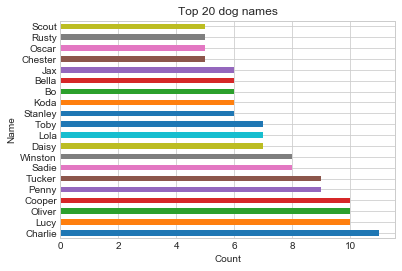

In [235]:
top20_names.plot(kind = 'barh')
plt.title('Top 20 dog names')
plt.xlabel('Count')
plt.ylabel('Name')

In [236]:
##### Dog breed analysis

In [237]:
# Dog breed analysis
breed = []
conf = []

def breed_conf(row):
    if row['p1_dog'] == True:
        breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        conf.append(0)

In [238]:
df.apply(breed_conf, axis=1)
df['breed'] = breed
df['conf'] = conf
df.head()

,Unnamed: 0,tweet_id,rating_numerator,rating_denominator,name,stage,year_x,month_x,day_x,rating,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,conf
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-01 16:23:56,0,892420643555336193,13,10,Phineas,None,2017,8,1,"13,10",...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,Unidentifiable,0.000000
2017-08-01 00:17:27,1,892177421306343426,13,10,Tilly,None,2017,8,1,"13,10",...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,Chihuahua,0.323581
2017-07-31 00:18:03,2,891815181378084864,12,10,Archie,None,2017,7,31,"12,10",...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,Chihuahua,0.716012
2017-07-30 15:58:51,3,891689557279858688,13,10,Darla,None,2017,7,30,"13,10",...,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False,Labrador Retriever,0.168086
2017-07-29 16:00:24,4,891327558926688256,12,10,Franklin,None,2017,7,29,"12,10",...,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True,Basset,0.555712


In [239]:
df_breeds = df.groupby(['breed'])['conf'].mean()
df_breeds.head()

breed
Afghan Hound                      0.433959
Airedale                          0.583771
American Staffordshire Terrier    0.527359
Appenzeller                       0.503665
Australian Terrier                0.307584
Name: conf, dtype: float64

In [240]:
df_breeds = df_breeds.sort_values(ascending = False).head(20)
df_breeds.head(20)

breed
Komondor                   0.972531
Clumber                    0.946718
Keeshond                   0.844431
Bull Mastiff               0.815618
Brittany Spaniel           0.775591
Bernese Mountain Dog       0.766685
Samoyed                    0.717440
Blenheim Spaniel           0.699588
German Shepherd            0.694426
Black-And-Tan Coonhound    0.692000
Pomeranian                 0.686306
Leonberg                   0.681635
Tibetan Mastiff            0.679344
Pembroke                   0.675733
Pug                        0.667843
Flat-Coated Retriever      0.664417
French Bulldog             0.662573
Japanese Spaniel           0.661178
Vizsla                     0.661060
Doberman                   0.654750
Name: conf, dtype: float64

Text(0,0.5,'Conf')

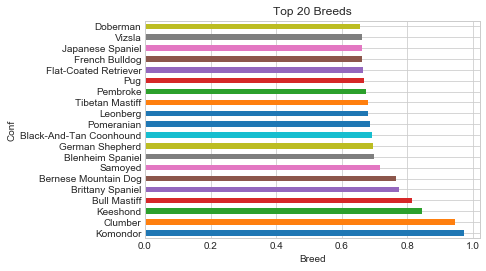

In [241]:
df_breeds.plot(y = 'conf', x = 'breed', kind = 'barh')
plt.title('Top 20 Breeds')
plt.xlabel('Breed')
plt.ylabel('Conf')

In this graph you can see the top 20 breeds with the highest score

##### Relationship between tweets and retweets and the final grade.

In [242]:
df[['favorite_count', 'retweet_count', 'rating_numerator']].corr()

,favorite_count,retweet_count,rating_numerator
favorite_count,1.000000,0.912947,0.009995
retweet_count,0.912947,1.000000,0.013879
rating_numerator,0.009995,0.013879,1.000000


Not the most punctuated ones are the most tweeted. **Possibly the most "nice" are more successful.**